<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
!nvidia-smi

Fri May 28 12:29:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
!pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

In [27]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/KenzaB27/segmentation-of-pelvic-bone
   50348c0..38ecf8e  main       -> origin/main
Updating 50348c0..38ecf8e
Fast-forward
 src/analysis.py | 10 ++++++----
 1 file changed, 6 insertions(+), 4 deletions(-)


In [20]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [9]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [64]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 9.64 s, sys: 743 ms, total: 10.4 s
Wall time: 10.4 s


In [48]:
print(f"X train shape:{data.X_train_3C.shape}, y train shape:{data.y_train.shape} ")
print(f"X val shape:{data.X_val_3C.shape}, y val shape:{data.y_val.shape} ")

X train shape:(815, 300, 300, 3), y train shape:(815,) 
X val shape:(43, 300, 300, 3), y val shape:(43,) 


In [30]:
data.X_flat_train.shape

(815, 90000)

In [31]:
print('Min: %.3f, Max: %.3f' % (data.cmn_img[42].min(), data.cmn_img[42].max()))

Min: -1024.000, Max: 3071.000


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.X_val_3C.min(), data.X_val_3C.max()))

Min: -2.628, Max: 1.531


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.X_flat_val.min(), data.X_flat_val.max()))

Min: -2.628, Max: 1.531


In [65]:
X_train, y_train, X_val, y_val = data.X_flat_train, data.y_train, data.X_flat_val, data.y_val

# Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0, n_jobs=-1, class_weight={0: 1, 1: 5})
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 5},
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [80]:
clf.score(X_val, y_val)

1.0

In [53]:
clf.classes_

array([0., 1.])

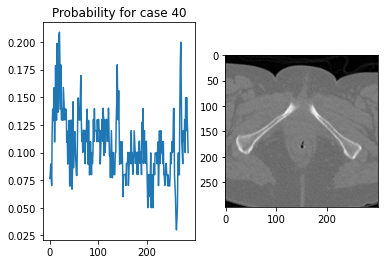

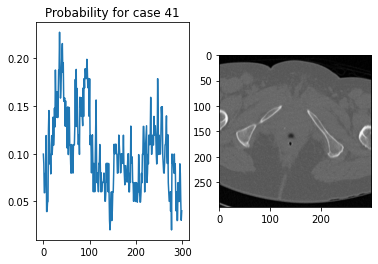

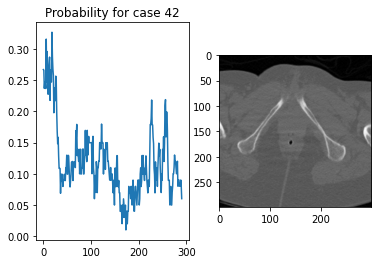

In [81]:
for id, cmn_img in data.cmn_img.items():
  X_flat = np.array([x.flatten() for x in cmn_img])
  X_flat = data.scaler.transform(X_flat)
  y_pred = clf.predict_proba(X_flat)[:,1]
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()

# SVM 

In [111]:
from sklearn import svm
clf = svm.SVC(kernel='poly', degree=2, probability=True, random_state=42).fit(X_train, y_train)

In [ ]:
clf.score(X_val, y_val)

In [100]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='poly', degree=3, probability=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)

In [101]:
scores

array([0.97546012, 0.95705521, 0.97546012, 0.94478528, 0.96319018])

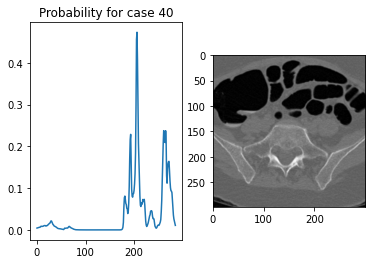

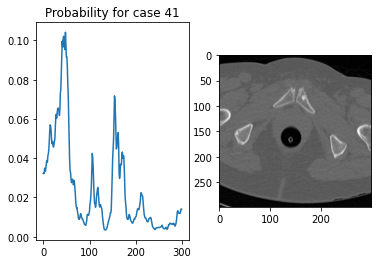

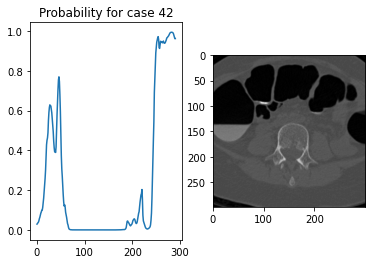

In [112]:
for id, cmn_img in data.cmn_img.items():
  X_flat = np.array([x.flatten() for x in cmn_img])
  X_flat = data.scaler.transform(X_flat)
  y_pred = clf.predict_proba(X_flat)[:,1]
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()